In [1]:
#General
import pandas as pd
import numpy as np
import json
import os
import polars as pl
import holidays
import datetime

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Style, init;


# Modeling
import xgboost as xgb
import lightgbm as lgb
import torch
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from sklego.preprocessing import RepeatingBasisFunction


# Geolocation
from geopy.geocoders import Nominatim

# Options
pd.set_option('display.max_columns', 200)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
import keras

import math
from sklearn.metrics import mean_squared_error

In [2]:
base_dir = "/kaggle/input/predict-energy-behavior-of-prosumers"

In [3]:
train = pd.read_csv(os.path.join(base_dir, 'train.csv'), parse_dates=True)

In [4]:
for i in range(0, 15):
    county = train[train['county']==i]
    print(f'county{i}: {county.shape[0]}')
train = train[train['county']==0]
train = train[train['is_consumption']==1]


county0: 212928
county1: 91872
county2: 115200
county3: 122496
county4: 147264
county5: 151632
county6: 30624
county7: 173088
county8: 91872
county9: 122496
county10: 134640
county11: 198000
county12: 30624
county13: 121056
county14: 125808


In [5]:
train = train.groupby(['datetime'])['target'].mean().reset_index()
train.head()

,datetime,target
0,2021-09-01 00:00:00,1081.096500
1,2021-09-01 01:00:00,1031.702667
2,2021-09-01 02:00:00,1023.151333
3,2021-09-01 03:00:00,1000.261500
4,2021-09-01 04:00:00,1025.369333


In [6]:
dataset = train
dataset["Month"] = pd.to_datetime(dataset["datetime"]).dt.month
dataset["Year"] = pd.to_datetime(dataset["datetime"]).dt.year
dataset["Date"] = pd.to_datetime(dataset["datetime"]).dt.date
dataset["Time"] = pd.to_datetime(dataset["datetime"]).dt.time
dataset["Week"] = pd.to_datetime(dataset["datetime"]).dt.isocalendar().week
dataset["Day"] = pd.to_datetime(dataset["datetime"]).dt.day_name()
dataset = dataset.set_index("datetime")
dataset.index = pd.to_datetime(dataset.index)

In [7]:
dataset = dataset[121:-72]

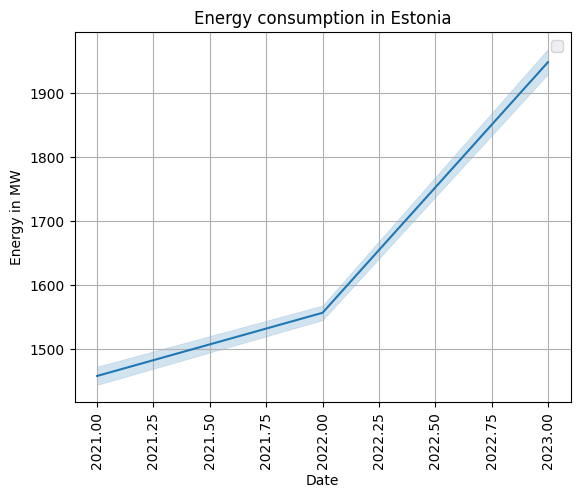

In [8]:
from matplotlib import style
fig = plt.figure()
axes1 = plt.subplot2grid((1,1), (0,0))

style.use("ggplot")
sns.lineplot(x= dataset["Year"], y= dataset["target"], data = dataset)
sns.set(rc={'figure.figsize': (14,6)})

plt.title("Energy consumption in Estonia")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True)
plt.legend()

for label in axes1.xaxis.get_ticklabels():
    label.set_rotation(90)

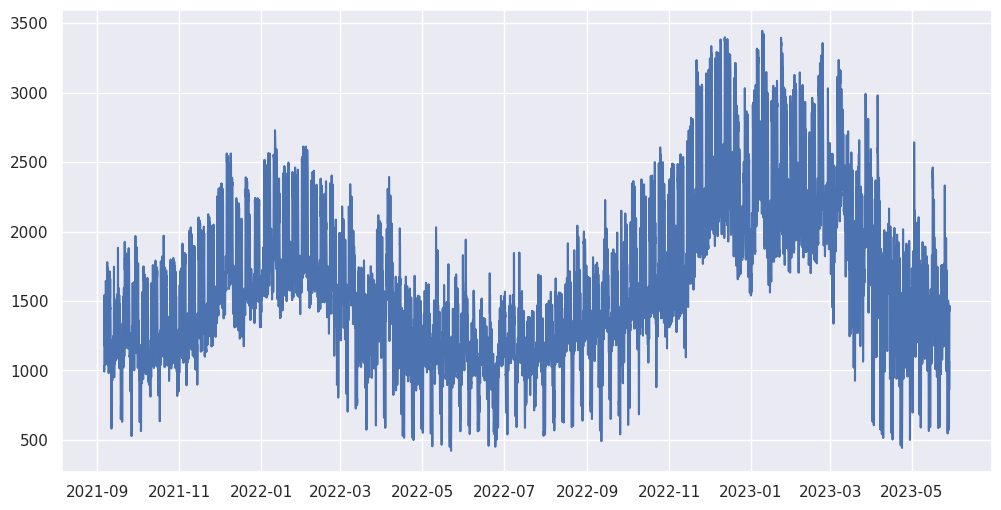

In [9]:
plt.figure(figsize=(12,6))
plt.plot(dataset["target"])

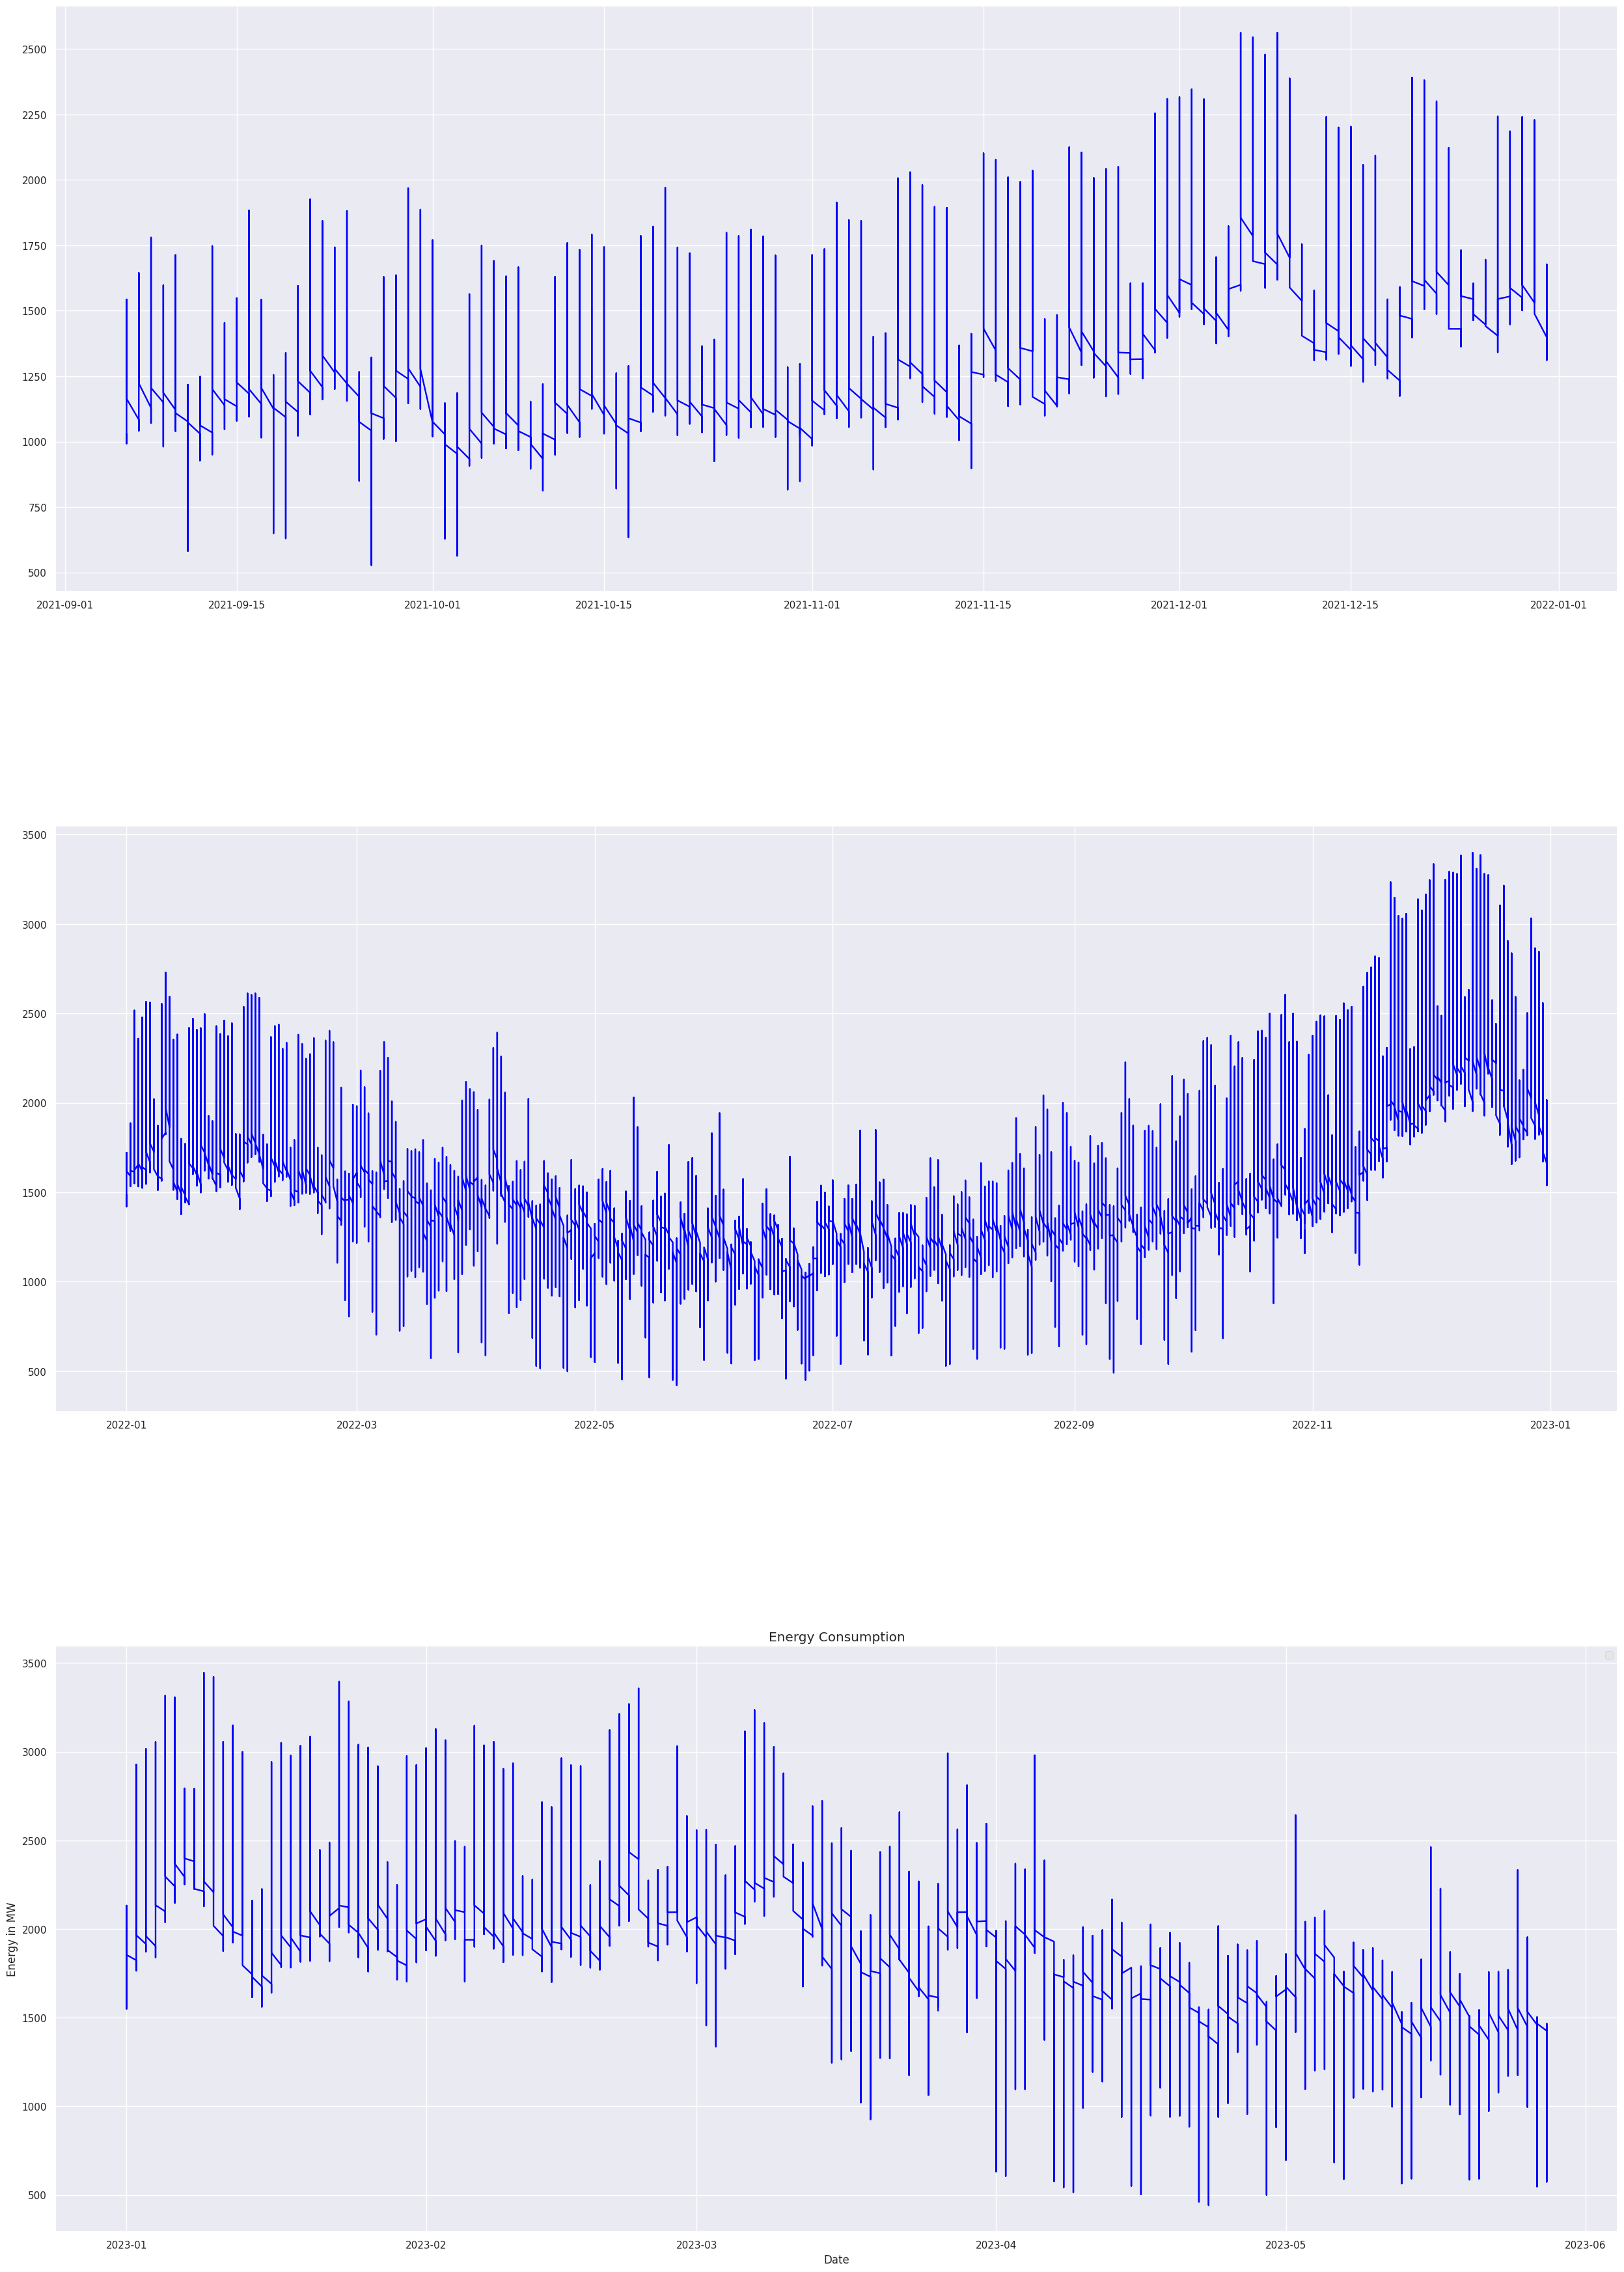

In [10]:
# Energy Consumption Each Year
from matplotlib import style

fig = plt.figure(figsize = (30,30))

ax1 = fig.add_subplot(611)
ax2 = fig.add_subplot(612)
ax3 = fig.add_subplot(613)

style.use("ggplot")

y_2016 = dataset.loc["2021"]["target"].to_list()
x_2016 = dataset.loc["2021"]["Date"].to_list()
ax1.plot(x_2016, y_2016, color= "blue", linewidth= 1.7)

y_2017 = dataset.loc["2022"]["target"].to_list()
x_2017 = dataset.loc["2022"]["Date"].to_list()
ax2.plot(x_2017, y_2017, color= "blue", linewidth= 1.7)

y_2018 = dataset.loc["2023"]["target"].to_list()
x_2018 = dataset.loc["2023"]["Date"].to_list()
ax3.plot(x_2018, y_2018, color= "blue", linewidth= 1.7)

plt.rcParams["figure.figsize"] = (30, 15)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=2.5, wspace=0.4, hspace=0.4)
plt.title("Energy Consumption")
plt.xlabel("Date")
plt.ylabel("Energy in MW")
plt.grid(True, alpha=1)
plt.legend()

/tmp/ipykernel_42/3821144039.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset["target"])


Text(0.5, 1.0, 'Energy Distribution')

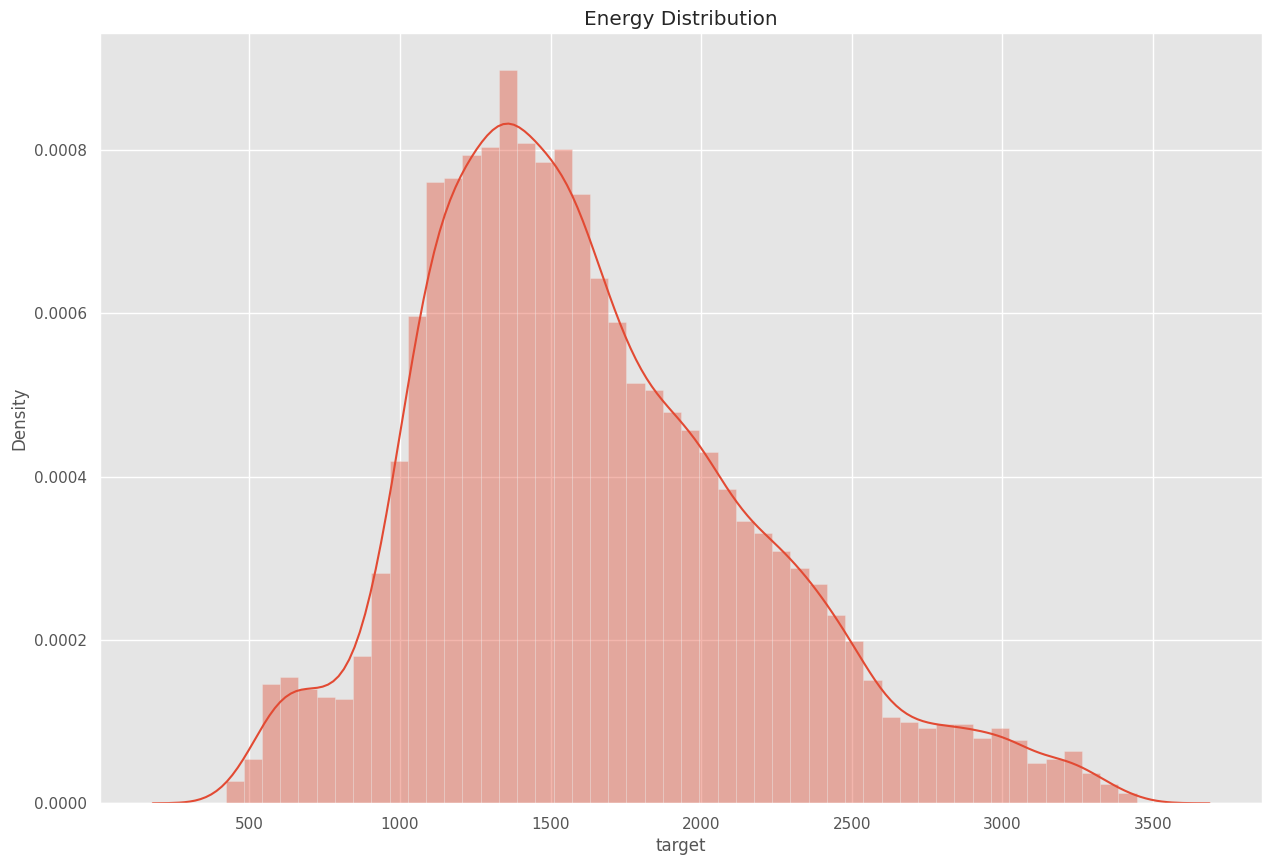

In [11]:

# Lets us see the Distribution off Energy Consumption so we have a idea about your Dataset a bit more
fig = plt.figure(figsize = (15,10))
sns.distplot(dataset["target"])
plt.title("Energy Distribution")

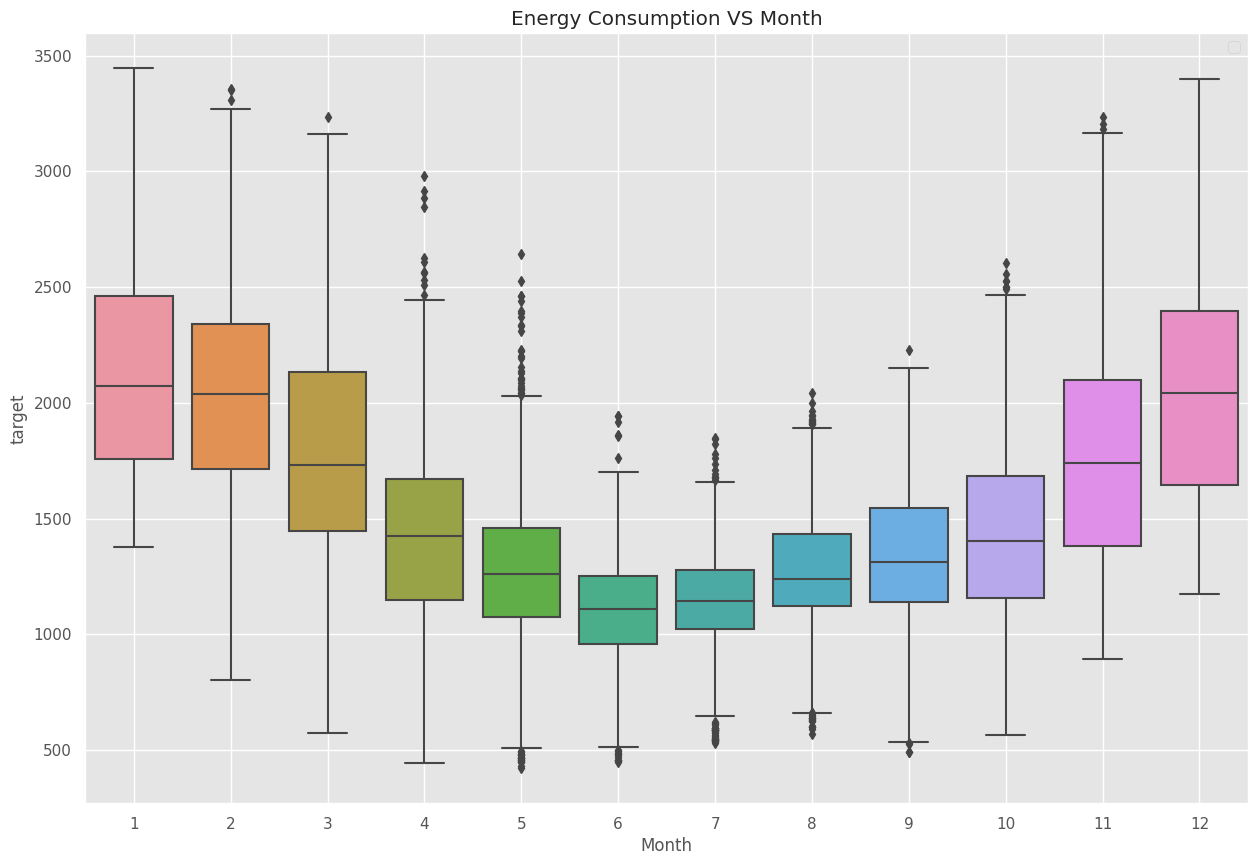

In [12]:

fig = plt.figure(figsize = (15,10))
sns.boxplot(x=dataset["Month"], y=dataset["target"], data= dataset)
plt.title("Energy Consumption VS Month")
plt.xlabel("Month")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

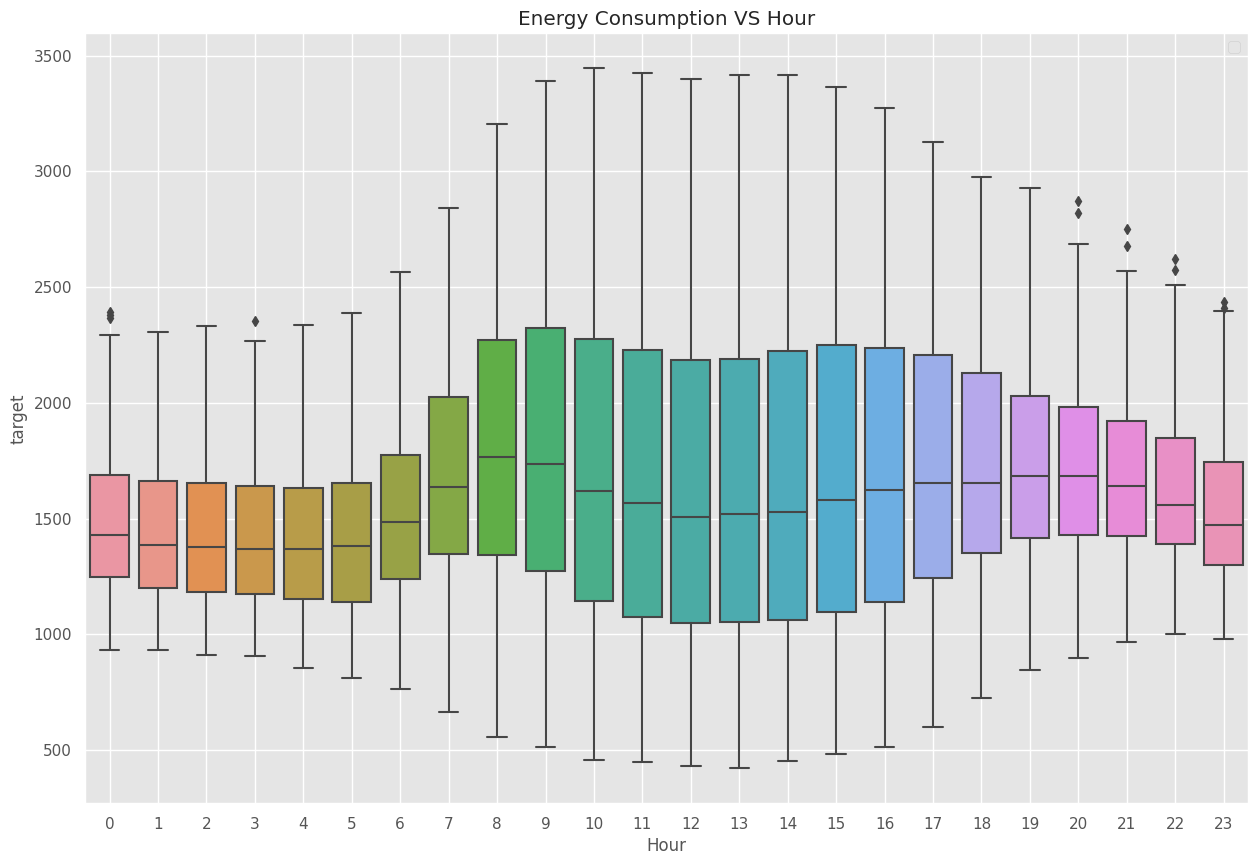

In [13]:
dataset1 = dataset
fig = plt.figure(figsize = (15,10))
sns.boxplot(x=dataset1.index.hour, y=dataset1.target, data= dataset)
plt.title("Energy Consumption VS Hour")
plt.xlabel("Hour")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

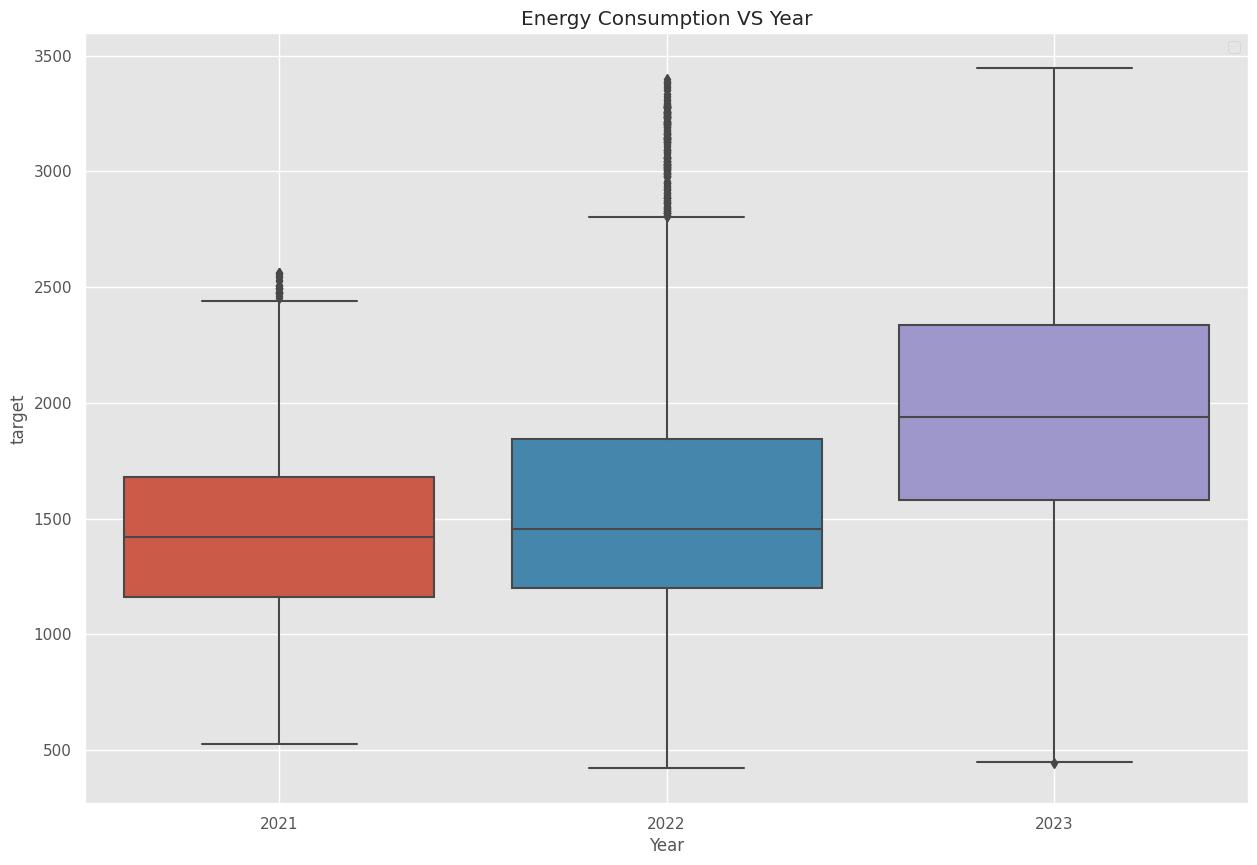

In [14]:

fig = plt.figure(figsize = (15,10))
sns.boxplot(x=dataset1.index.year, y=dataset1.target, data= dataset)
plt.title("Energy Consumption VS Year")
plt.xlabel("Year")
plt.grid(True, alpha=1)
plt.legend()

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

In [15]:
# Downsampling involves decreasing the time-frequency of the data
# Downsapling the time-frequency from hours to days 
dataset = dataset.drop(['Time', 'Day', 'Date'], axis=1)
newDataSet = dataset.resample("D").mean()
newDataSet.head()

,target,Month,Year,Week
datetime,,,,
2021-09-06,1257.360790,9.0,2021.0,36.0
2021-09-07,1304.345632,9.0,2021.0,36.0
2021-09-08,1424.701833,9.0,2021.0,36.0
2021-09-09,1217.544542,9.0,2021.0,36.0
2021-09-10,1378.657681,9.0,2021.0,36.0


In [16]:
y = newDataSet["target"]
print(y[0])
y.shape


1257.3607898550724


(630,)

In [17]:
# Normalize data before model fitting
# it will boost the performance( in neural networks) + transform
from sklearn.preprocessing import MinMaxScaler
# scale of the output and input inthe range 0-1 to match the scale of the layer of LSTM
scaler = MinMaxScaler(feature_range = (0,1)) 
# reshape: convert the univariate 1D array into 2D
y = scaler.fit_transform(np.array(y).reshape(-1,1))
print("Normalizing data before model fitting")
print(y[:10])

Normalizing data before model fitting
[[0.25195887]
 [0.2748145 ]
 [0.33336139]
 [0.23259039]
 [0.31096336]
 [0.09878796]
 [0.15327725]
 [0.2493328 ]
 [0.24029746]
 [0.29167115]]


In [18]:
training_size = int(len(y)*0.80)
val_size = int(len(y)*0.90)
train_data = y[0:training_size,:]
val_data = y[training_size:val_size,:]
test_data = y[val_size:,:]


In [19]:
# building input variable
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [] , []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step,0])
    return np.array(dataX), np.array(dataY)

In [20]:
time_step = 2
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)


In [21]:
# reshape train and input-output pairs
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1],1)

print("X_train shape: ", X_train.shape)
print("X_test shape: ",X_test.shape)
print("X_val shape: ",X_val.shape)

X_train shape:  (501, 2, 1)
X_test shape:  (60, 2, 1)
X_val shape:  (60, 2, 1)


In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (time_step, 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 2, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 2, 50)             20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 

In [24]:
history = model.fit(X_train, y_train, validation_data = (X_val,yval), verbose = 1,epochs = 60 ,batch_size = 20)


Epoch 1/60
26/26 [==============================] - 11s 102ms/step - loss: 0.1402 - val_loss: 0.1197
Epoch 2/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0405 - val_loss: 0.0865
Epoch 3/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0302 - val_loss: 0.0449
Epoch 4/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0194 - val_loss: 0.0210
Epoch 5/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0164 - val_loss: 0.0199
Epoch 6/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0170 - val_loss: 0.0181
Epoch 7/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0160 - val_loss: 0.0193
Epoch 8/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0167 - val_loss: 0.0202
Epoch 9/60
26/26 [==============================] - 0s 11ms/step - loss: 0.0164 - val_loss: 0.0186
Epoch 10/60
26/26 [==============================] - 0s 10ms/step - loss: 0.0160 - val_loss: 0.0175
Epoch 1

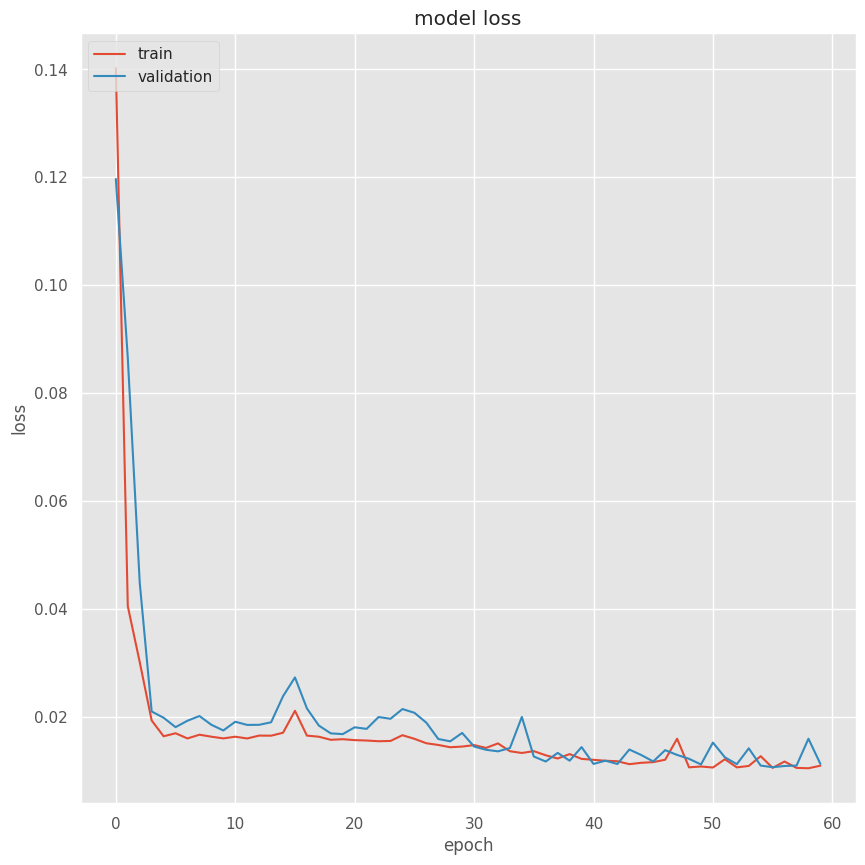

In [25]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [27]:
mae = mean_absolute_error(ytest, test_predict)
print('MAE Test Data: '+str(mae))
rmse = np.sqrt(mean_squared_error(ytest, test_predict))
print('RMSE Test Data: '+str(rmse))

mae = mean_absolute_error(y_train, train_predict)
print('MAE Train Data: '+str(mae))
rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print('RMSE Train Data: '+str(rmse))


MAE Test Data: 0.08918725851624605
RMSE Test Data: 0.11737617609531659
MAE Train Data: 0.07476506773900779
RMSE Train Data: 0.09815479739771522


In [28]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
val_predict=scaler.inverse_transform(val_predict)
     

In [29]:
print(train_predict.shape)
print(test_predict.shape)
print(val_predict.shape)
print(train_predict[0])
print(y_train.shape)


(501, 1)
(60, 1)
(60, 1)
[1346.0621]
(501,)


In [30]:
# Predicting consumption using training data
train_predictions = model.predict(X_train)
train_predictions =scaler.inverse_transform(train_predictions)

y_train = y_train.reshape(y_train.shape[0], 1)
actual = scaler.inverse_transform(y_train)
train_results = pd.DataFrame()

train_results["Train Predictions"] = train_predictions.tolist()
train_results["Actuals"] = actual.tolist()

train_results

16/16 [==============================] - 0s 4ms/step


,Train Predictions,Actuals
0,[1346.0621337890625],[1424.7018333333333]
1,[1443.3287353515625],[1217.5445416666666]
2,[1276.26123046875],[1378.6576805555558]
3,[1405.1845703125],[942.4837777777778]
4,[1076.1102294921875],[1054.4986944444445]
...,...,...
496,[2297.235595703125],[2462.240714285714]
497,[2417.453369140625],[2390.229553571429]
498,[2321.123046875],[2447.8774761904765]
499,[2394.787353515625],[2490.4143452380954]


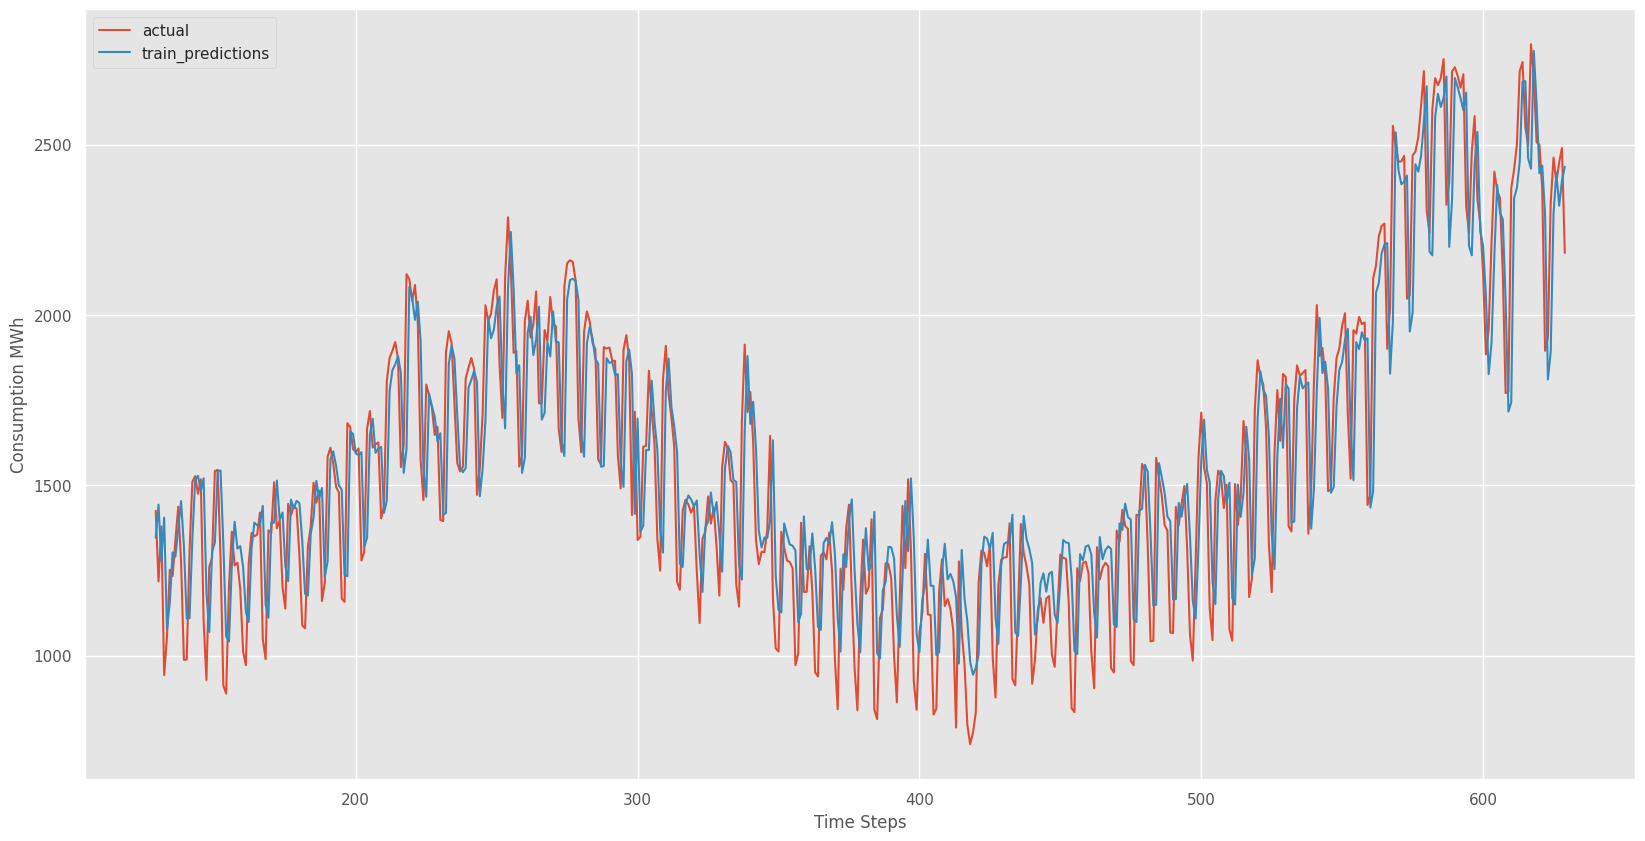

In [31]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[129:, :] = actual.tolist()
plt.plot(ActualPlot)

TrainPredictionsPlot = np.empty_like(y )
TrainPredictionsPlot[:, :] = np.nan
TrainPredictionsPlot[129:, :] = train_predictions.tolist()
plt.plot(TrainPredictionsPlot)

plt.legend(['actual','train_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')
plt.show()

In [32]:
# Predicting consumption using validation data
val_predictions = model.predict(X_val)
val_predictions =scaler.inverse_transform(val_predictions)

yval = yval.reshape(yval.shape[0], 1)
actual_val = scaler.inverse_transform(yval)

val_results = pd.DataFrame()
val_results["Val Predictions"] = val_predictions.tolist()
val_results["Actuals_val"] = actual_val.tolist()

val_results

2/2 [==============================] - 0s 5ms/step


,Val Predictions,Actuals_val
0,[2514.1611328125],[2475.7231607142858]
1,[2397.586669921875],[2447.774875]
2,[2383.8642578125],[2414.515244047619]
3,[2350.2451171875],[2075.606839285714]
4,[1987.3243408203125],[1957.0737500000002]
5,[1902.5447998046875],[2360.8558988095238]
6,[2330.04443359375],[2345.7845892857144]
7,[2284.69775390625],[2463.6644285714287]
8,[2417.3515625],[2431.989726190476]
9,[2367.732666015625],[2538.2420654761904]


Text(0, 0.5, 'Consumption MWh')

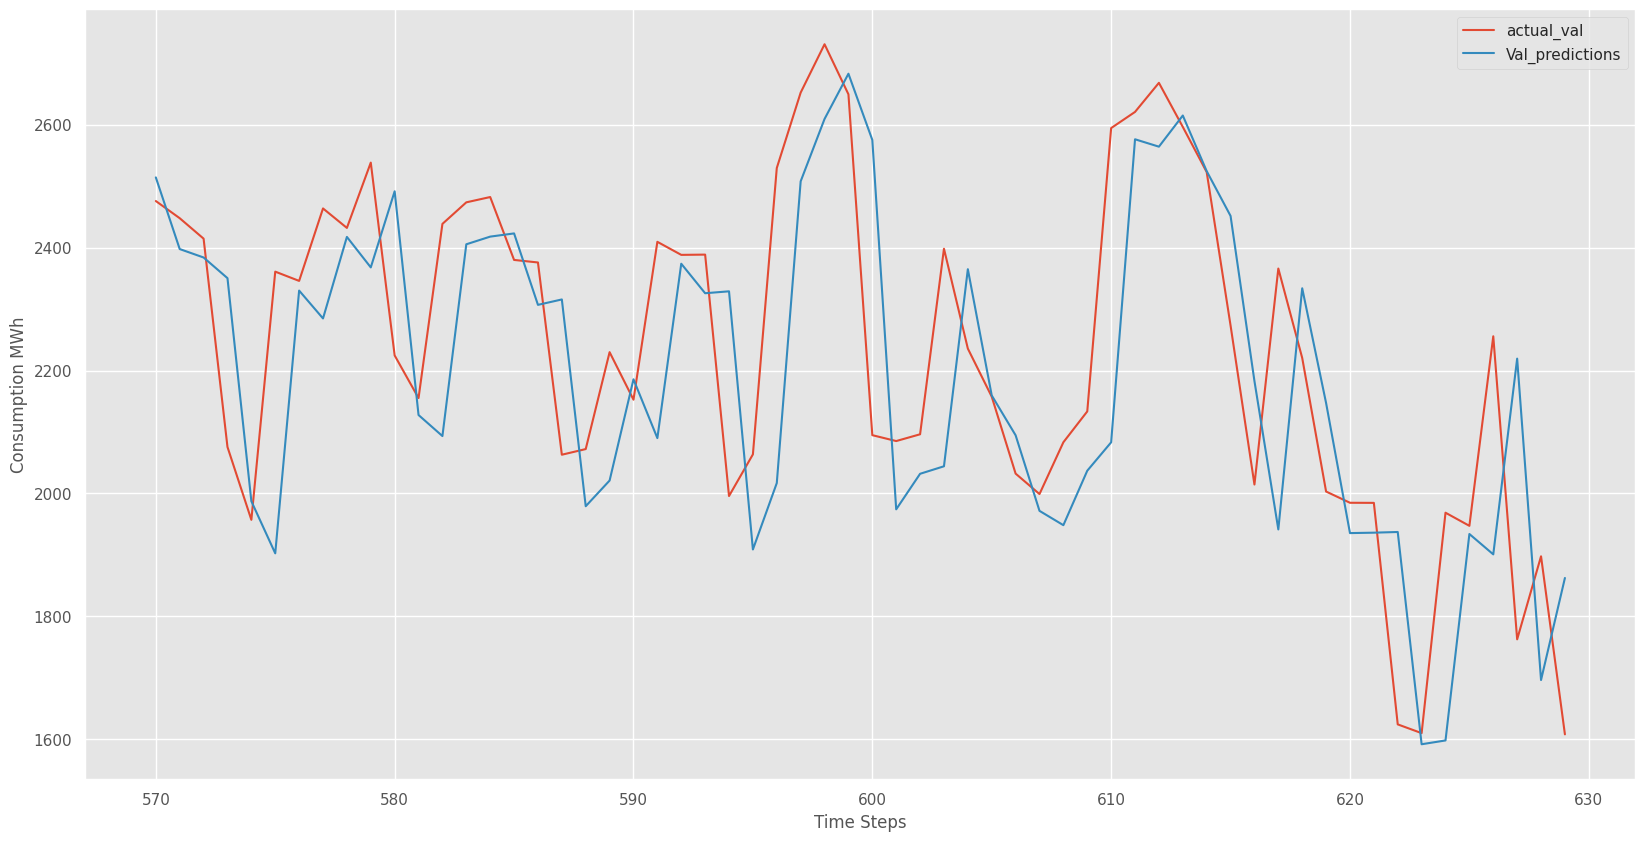

In [33]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[570:, :] = actual_val.tolist()
plt.plot(ActualPlot)

# Validation Prediction
ValPredictionsPlot = np.empty_like(y)
ValPredictionsPlot[:, :] = np.nan
ValPredictionsPlot[570:, :] = val_predictions.tolist()
plt.plot(ValPredictionsPlot)

plt.legend(['actual_val','Val_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')

In [34]:
# Predicting consumption using test data
test_predictions = model.predict(X_test)
test_predictions =scaler.inverse_transform(test_predictions)

ytest = ytest.reshape(ytest.shape[0], 1)
actual_test = scaler.inverse_transform(ytest)

test_results = pd.DataFrame()
test_results["test Predictions"] = test_predictions.tolist()
test_results["Actuals_test"] = actual_test.tolist()

test_results

2/2 [==============================] - 0s 6ms/step


,test Predictions,Actuals_test
0,[2035.4708251953125],[2052.756803571429]
1,[1996.59814453125],[2160.0959702380956]
2,[2113.332763671875],[2140.275660714286]
3,[2083.868896484375],[1476.4029464285713]
4,[1453.103759765625],[1408.5036666666667]
5,[1428.259033203125],[1756.4144642857143]
6,[1732.3194580078125],[1779.629398809524]
7,[1749.31591796875],[2356.8033095238093]
8,[2326.0185546875],[2004.4988035714287]
9,[1921.52392578125],[1350.8023928571429]


Text(0, 0.5, 'Consumption MWh')

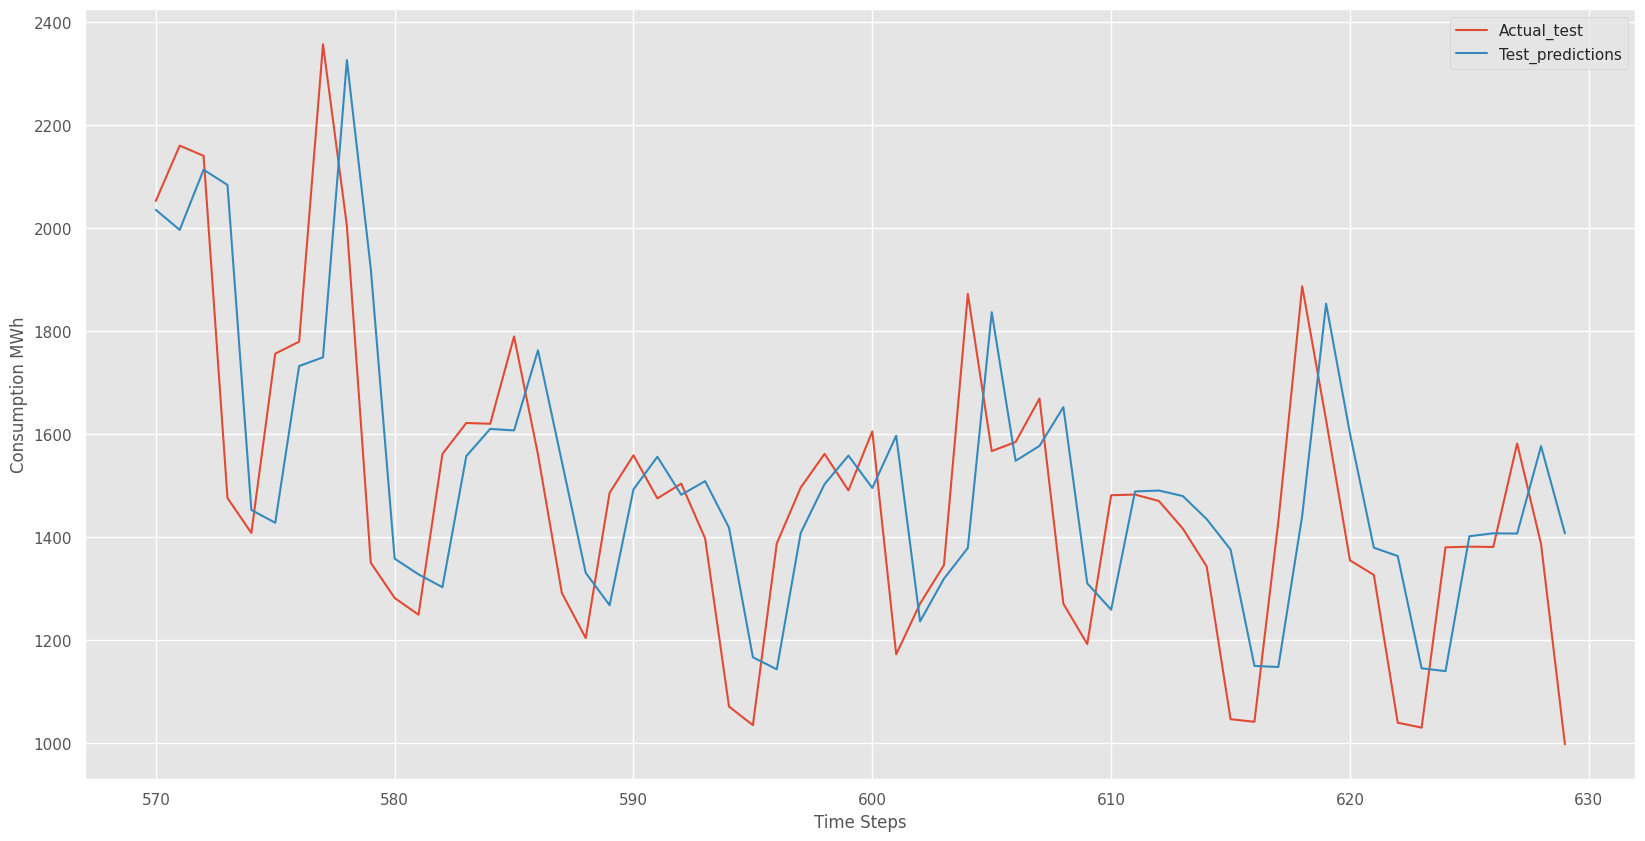

In [35]:
plt.figure(figsize=(20,10))

# Actual Consumption
ActualPlot = np.empty_like(y)
ActualPlot[:, :] = np.nan
ActualPlot[570:, :] = actual_test.tolist()
plt.plot(ActualPlot)

# Test Prediction
TestPredictionsPlot = np.empty_like(y)
TestPredictionsPlot[:, :] = np.nan
TestPredictionsPlot[570:, :] = test_predictions.tolist()
plt.plot(TestPredictionsPlot)

plt.legend(['Actual_test','Test_predictions'])
plt.xlabel('Time Steps')
plt.ylabel('Consumption MWh')

In [36]:
# ### Plotting 
# # shift train predictions for plotting
# look_back=100 #*****************************************>>>>>100
# fig, ax = plt.subplots(figsize=(20,10))
# trainPredictPlot = np.empty_like(y)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# # shift test predictions for plotting
# testPredictPlot = np.empty_like(y)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(train_predict)+(look_back*2)+1+349:len(y)-1, :] = test_predict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(y))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.legend(['inverse_transform(y)','trainPredictPlot','testPredictPlot'])
# plt.xlabel('Time Steps')
# plt.ylabel('Consumption MWh')
# plt.show()

In [37]:
print(len(test_data))
print(test_data[0])
print(len(train_data))
x_input=test_data[337:].reshape(1,-1)
print(x_input.shape)
# print(x_input[0])
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
# print(temp_input)

63
[0.79022026]
504
(1, 0)


In [38]:
# # demonstrate prediction for next 30 days
# from numpy import array

# lst_output=[]
# n_steps=100
# i=0
# test = ""
# while(i<30):
    
#     if(len(temp_input)>100):
#         test = "if"
#         #print(temp_input)
#         x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
#         x_input=x_input.reshape(1,-1)
#         x_input = x_input.reshape((1, n_steps, 1))
#         #print(x_input)
#         yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         test="else"
#         x_input = x_input.reshape((1, n_steps,1))
#         yhat = model.predict(x_input, verbose=0)
#         #print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         #print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1

    
# print(test)
# print(len(lst_output))

In [39]:
# print(len(y))
# day_new=np.arange(1,101)
# day_pred=np.arange(101, 131 )
# plt.figure(figsize = (15,10))
# plt.plot(day_new,scaler.inverse_transform(y[2084:]))
# plt.plot(day_pred,scaler.inverse_transform(lst_output))
# print(scaler.inverse_transform(lst_output))

In [40]:
# df3=y.tolist()
# df3.extend(lst_output)
# plt.figure(figsize=(15,10))
# plt.plot(df3[2000:])


In [41]:
from keras.layers import Bidirectional

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, return_sequences = True, input_shape = (time_step, 1))))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
# model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, return_sequences = True)))
# model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50)))
# model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mse')

In [43]:
# model.summary()

In [44]:
history = model.fit(X_train, y_train, validation_data = (X_val,yval), verbose = 1,epochs = 60 ,batch_size = 10)


Epoch 1/60
51/51 [==============================] - 22s 77ms/step - loss: 0.0634 - val_loss: 0.0392
Epoch 2/60
51/51 [==============================] - 1s 12ms/step - loss: 0.0160 - val_loss: 0.0138
Epoch 3/60
51/51 [==============================] - 1s 13ms/step - loss: 0.0130 - val_loss: 0.0142
Epoch 4/60
51/51 [==============================] - 1s 13ms/step - loss: 0.0130 - val_loss: 0.0149
Epoch 5/60
51/51 [==============================] - 1s 12ms/step - loss: 0.0132 - val_loss: 0.0175
Epoch 6/60
51/51 [==============================] - 1s 12ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 7/60
51/51 [==============================] - 1s 12ms/step - loss: 0.0124 - val_loss: 0.0145
Epoch 8/60
51/51 [==============================] - 1s 12ms/step - loss: 0.0134 - val_loss: 0.0148
Epoch 9/60
51/51 [==============================] - 1s 15ms/step - loss: 0.0136 - val_loss: 0.0115
Epoch 10/60
51/51 [==============================] - 1s 15ms/step - loss: 0.0126 - val_loss: 0.0162
Epoch 11

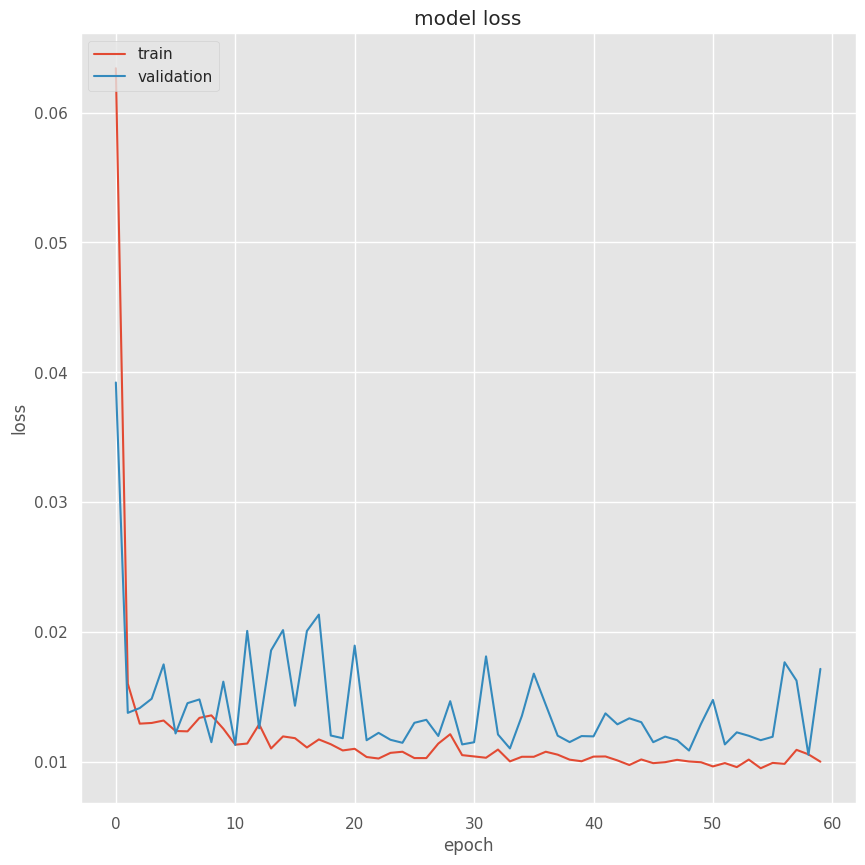

In [45]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss']) # tb
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
val_predict=model.predict(X_test)

2/2 [==============================] - 0s 7ms/step


In [47]:
mae = mean_absolute_error(ytest, test_predict)
print('MAE Test Data: '+str(mae))
rmse = np.sqrt(mean_squared_error(ytest, test_predict))
print('RMSE Test Data: '+str(rmse))

mae = mean_absolute_error(y_train, train_predict)
print('MAE Train Data: '+str(mae))
rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print('RMSE Train Data: '+str(rmse))

MAE Test Data: 0.09082575389007448
RMSE Test Data: 0.11682001786250334
MAE Train Data: 0.0840338151952239
RMSE Train Data: 0.10580177892477446


In [48]:
from statsmodels.tsa.arima.model import ARIMA


In [49]:
y = newDataSet.copy().filter(['target'])

In [50]:
train_data, test_data = y[0:int(len(y)*0.9)], y[int(len(y)*0.9):]
model = ARIMA(y, order=(5,1,0), seasonal_order = (1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             target   No. Observations:                  630
Model:             ARIMA(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -4056.165
Date:                            Thu, 18 Jan 2024   AIC                           8128.329
Time:                                    11:49:45   BIC                           8163.728
Sample:                                09-06-2021   HQIC                          8142.092
                                     - 05-28-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2200      0.034     -6.476      0.000      -0.287      -0.153
ar.L2         -0.4830      0.031   

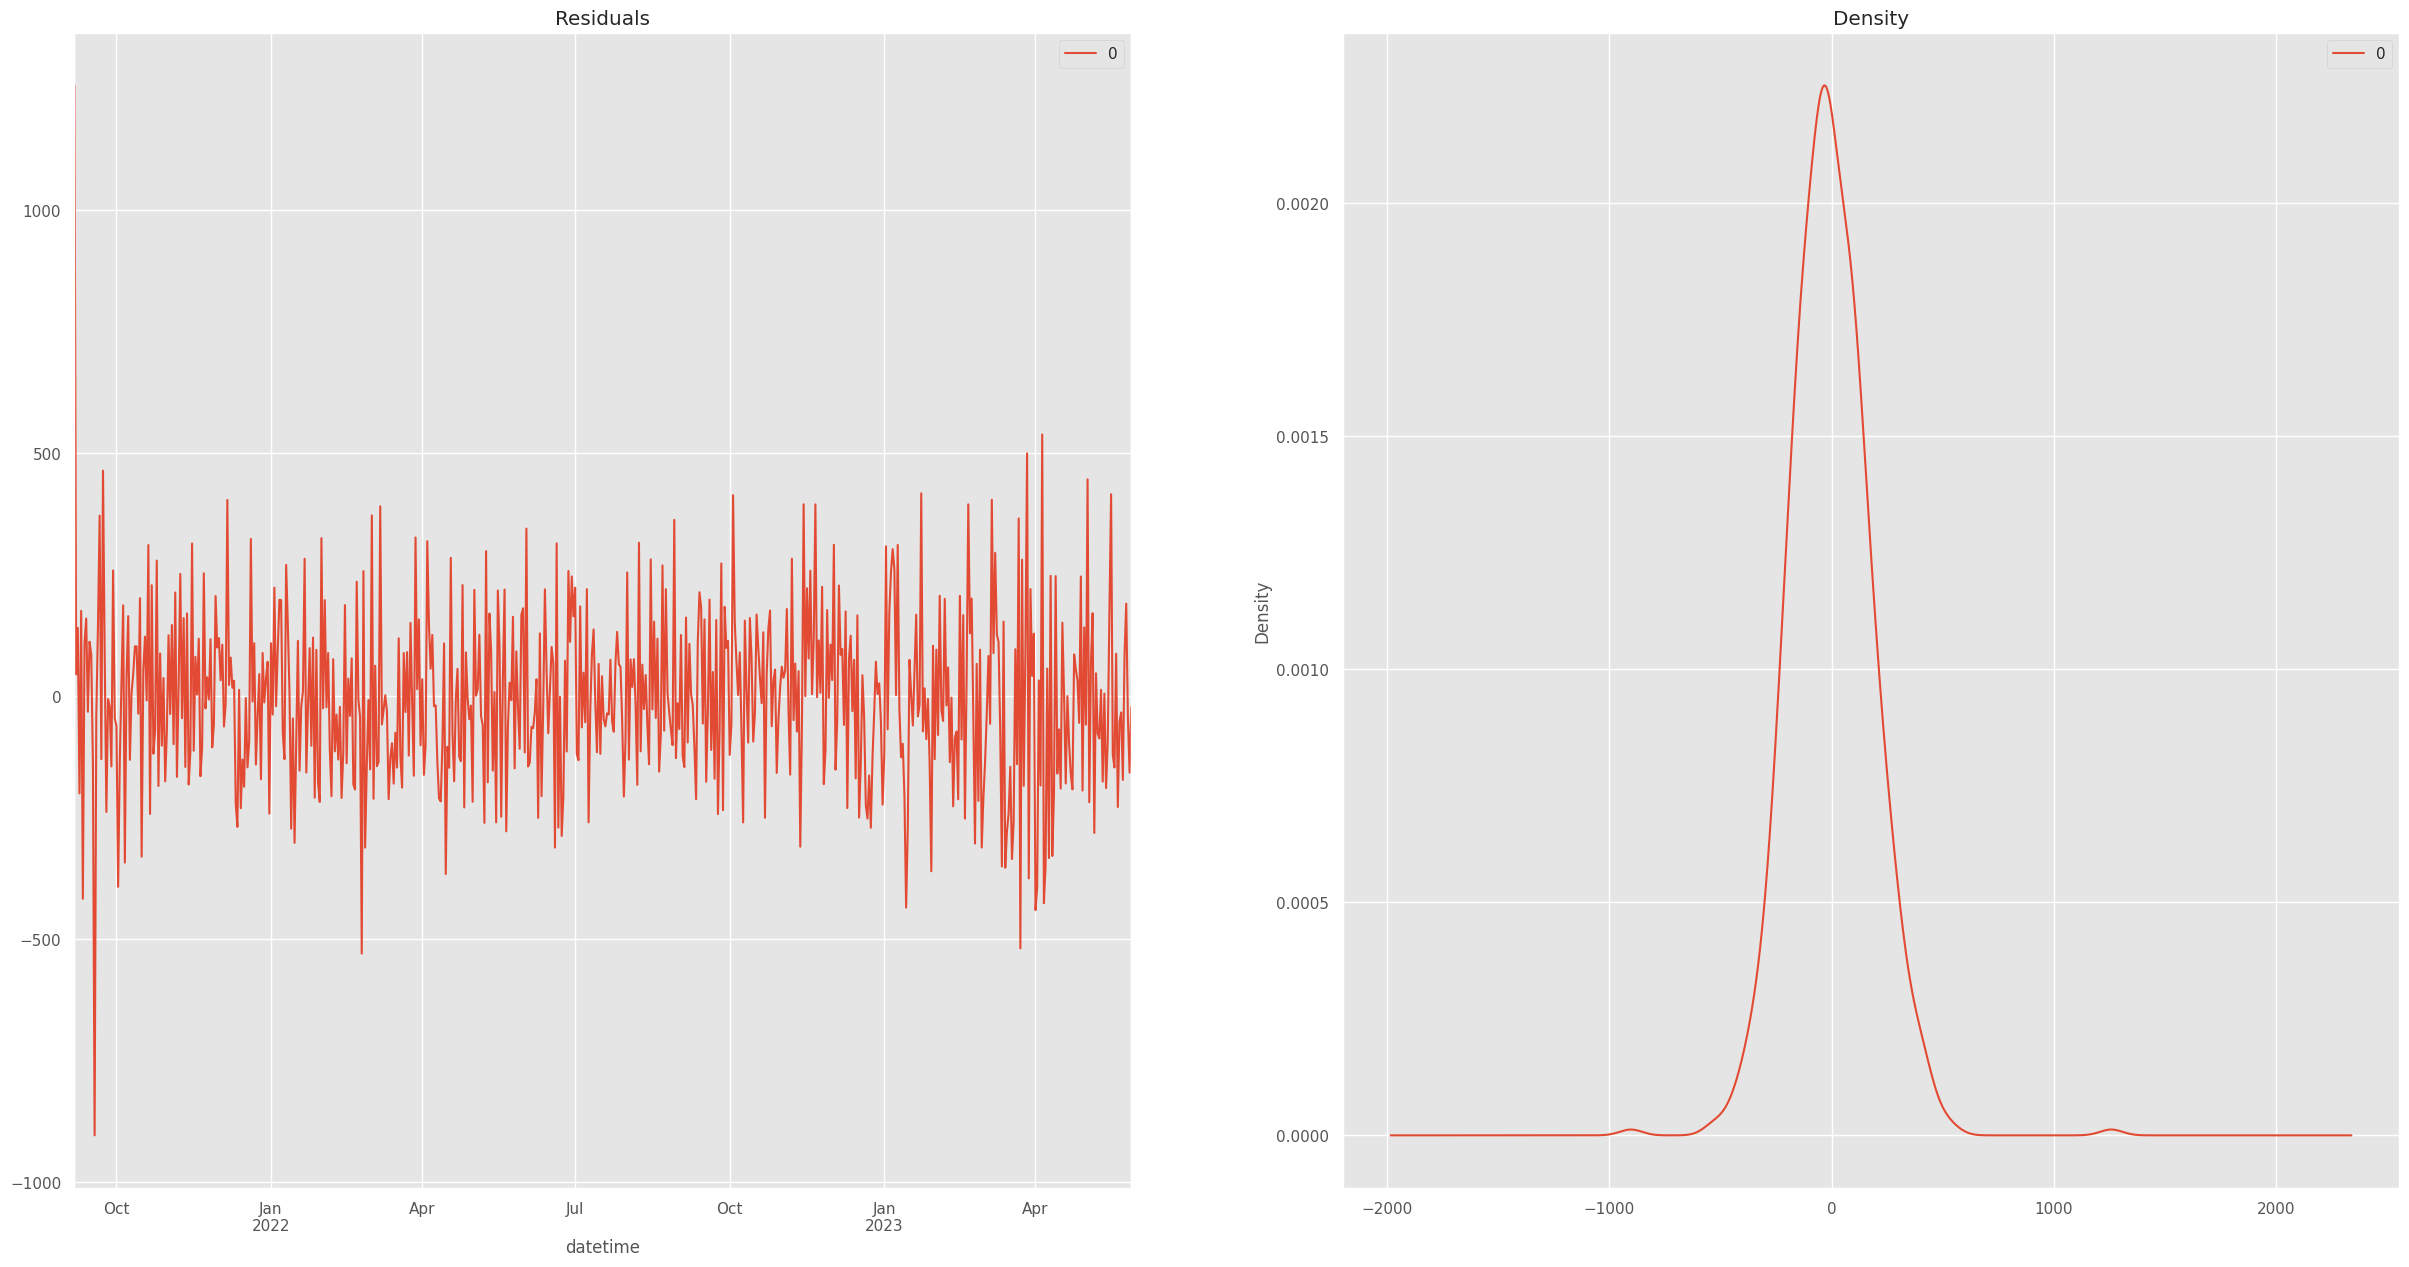

In [51]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [52]:
arima_pred = model_fit.predict(start = len(train_data), end = len(y)-1, typ="levels")


In [53]:
test_data['SARIMA_Predictions'] = arima_pred.copy()

/tmp/ipykernel_42/11370981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['SARIMA_Predictions'] = arima_pred.copy()


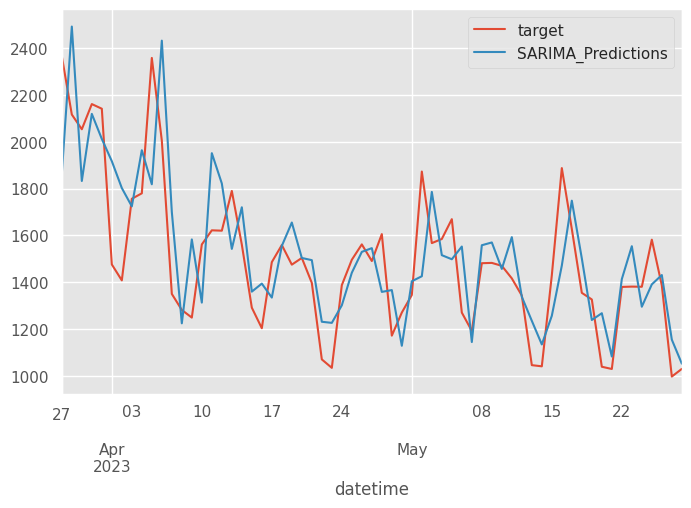

In [54]:
test_data['target'].plot(figsize = (8,5), legend=True)
test_data['SARIMA_Predictions'].plot(legend = True);

In [55]:
mae = mean_absolute_error(test_data['target'], arima_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['target'], arima_pred))
print('RMSE: '+str(rmse))

MAE: 173.30587982612045
RMSE: 218.3518522034742


In [56]:
y = newDataSet.copy().filter(['target'])

In [57]:
train_data, test_data = y[0:int(len(y)*0.9)], y[int(len(y)*0.9):]
model = ARIMA(y, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                  630
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4110.241
Date:                Thu, 18 Jan 2024   AIC                           8232.482
Time:                        11:49:48   BIC                           8259.147
Sample:                    09-06-2021   HQIC                          8242.840
                         - 05-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2062      0.034     -6.142      0.000      -0.272      -0.140
ar.L2         -0.5033      0.029    -17.117      0.000      -0.561      -0.446
ar.L3         -0.3598      0.036     -9.903      0.0

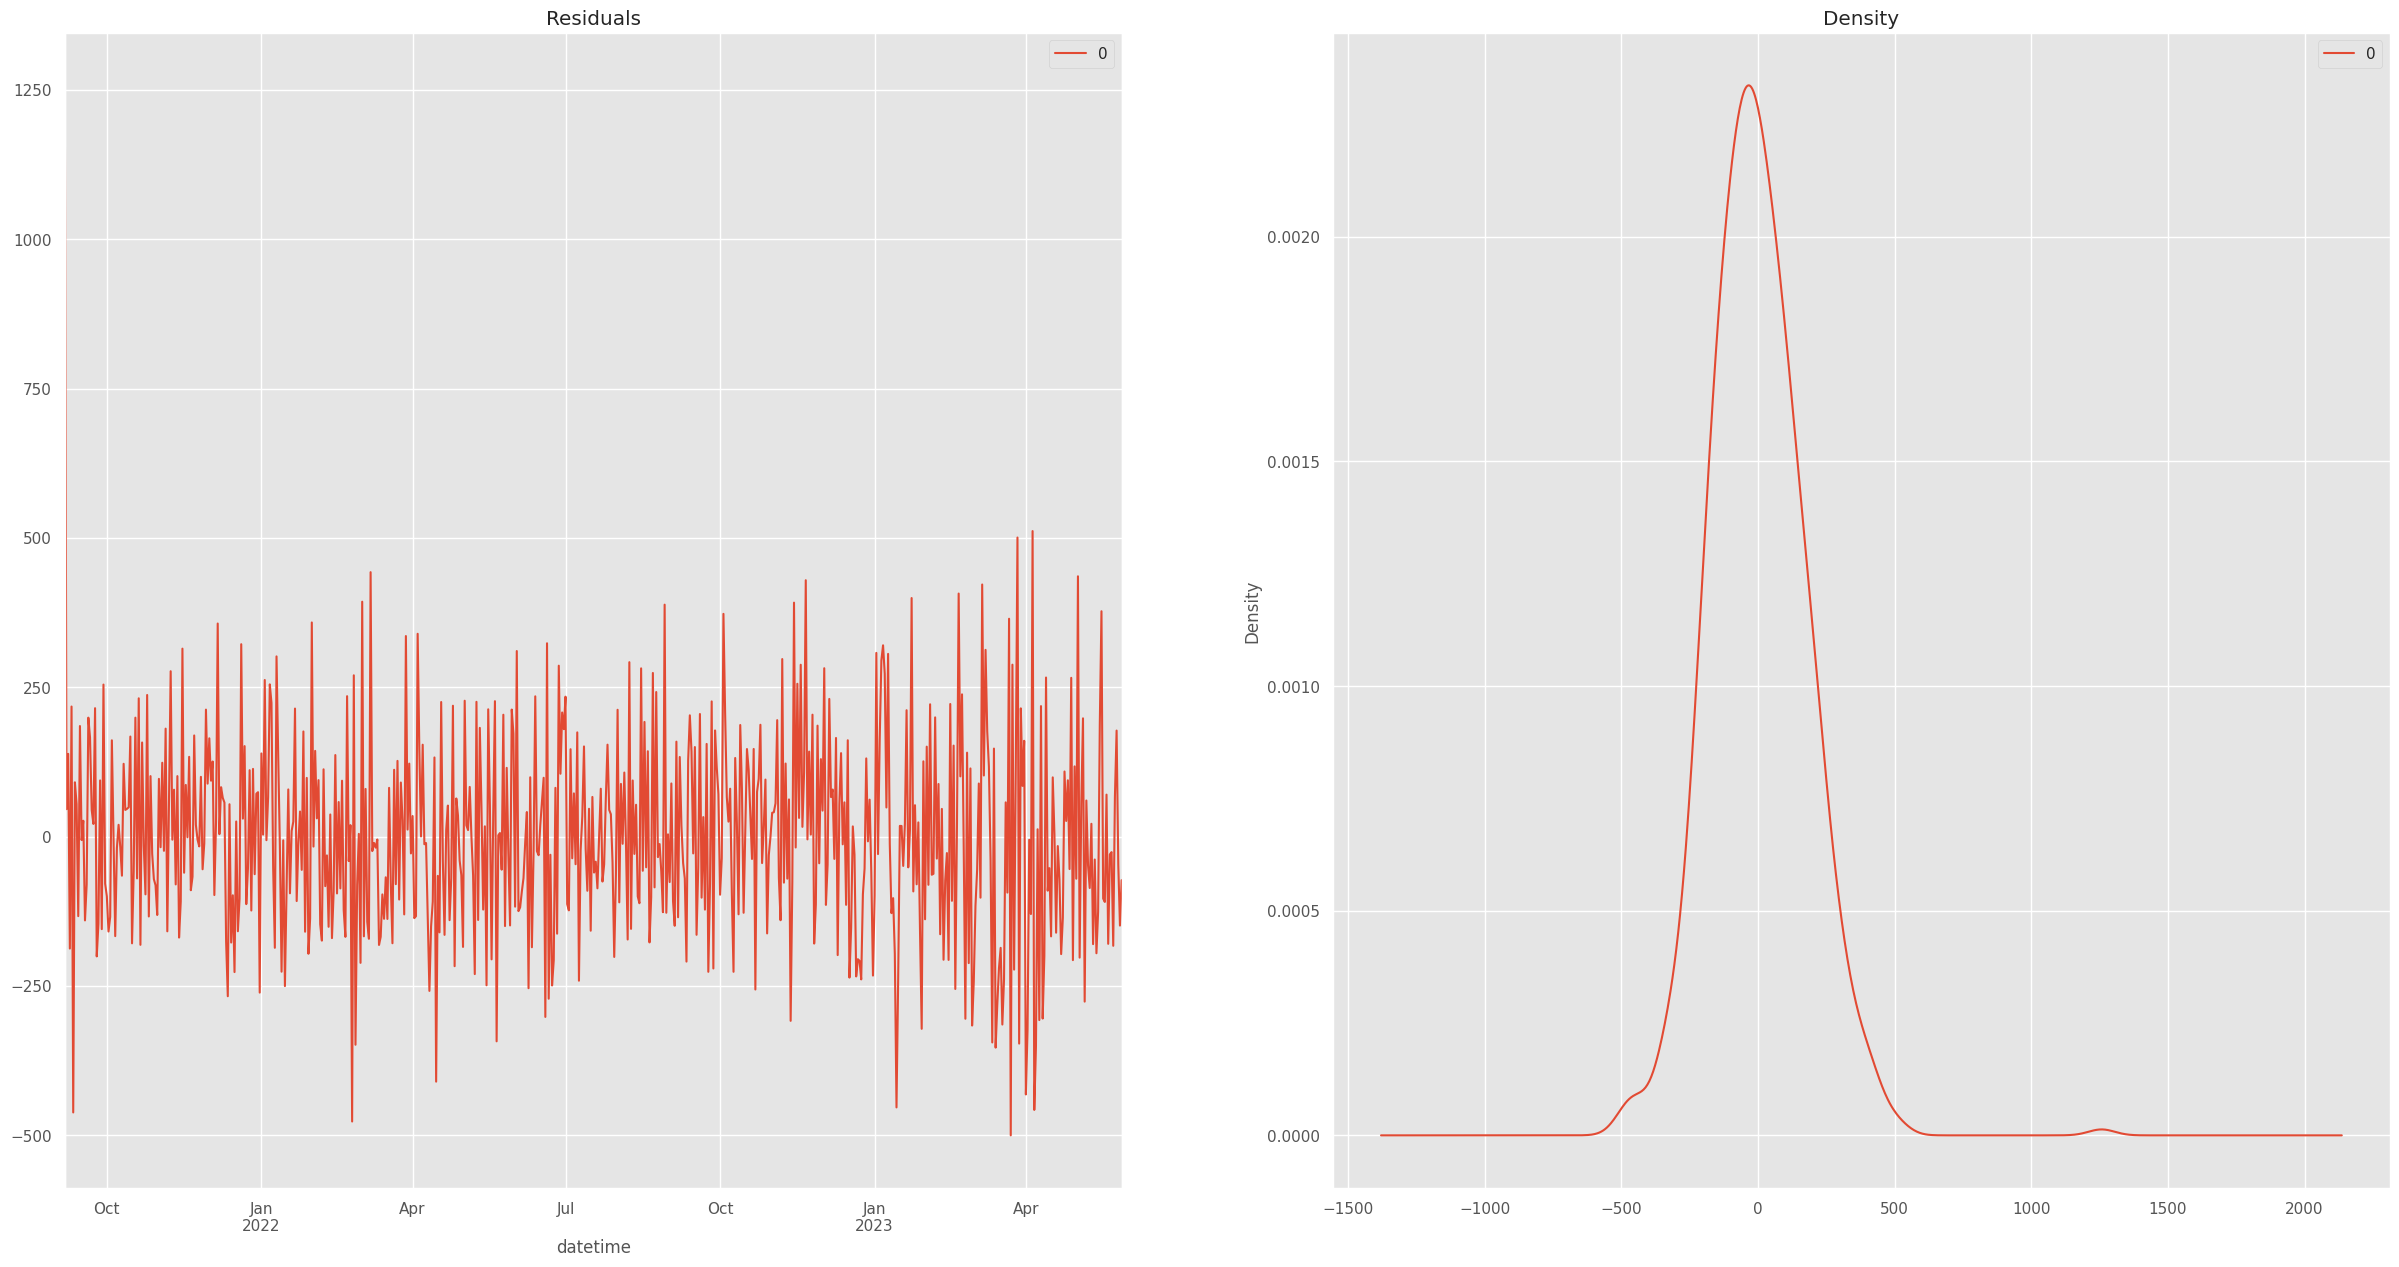

In [58]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [59]:
arima_pred = model_fit.predict(start = len(train_data), end = len(y)-1, typ="levels")


In [60]:
test_data['ARIMA_Predictions'] = arima_pred.copy()

/tmp/ipykernel_42/492699810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ARIMA_Predictions'] = arima_pred.copy()


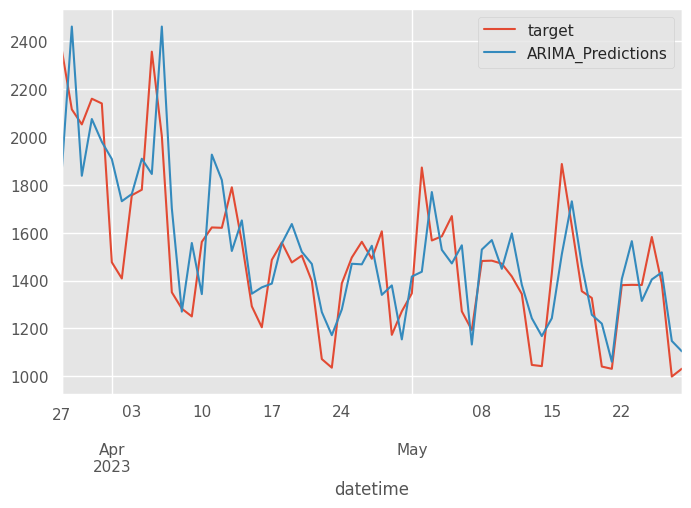

In [61]:
test_data['target'].plot(figsize = (8,5), legend=True)
test_data['ARIMA_Predictions'].plot(legend = True);

In [62]:
mae = mean_absolute_error(test_data['target'], arima_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data['target'], arima_pred))
print('RMSE: '+str(rmse))

MAE: 166.1099882728299
RMSE: 210.0311701133402
